<a href="https://colab.research.google.com/github/Saksham9804/Spider-task/blob/codespace-fictional-engine-x594grgj4r6p2rwx/domain_specific_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#TASK 1-A

# ===== Setup and Imports =====
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# Use GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ===== Data Preparation =====
# Define how to transform images (normalize and convert to tensor)
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the EMNIST Balanced dataset
train_set = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=image_transform)
test_set = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=image_transform)

# Split training set into training and validation
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_set, val_set = random_split(train_set, [train_size, val_size])

# Create data loaders for batching
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# ===== Model Definition =====
class EMNISTModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Feature extraction (convolutions and pooling)
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # Flatten the output for fully connected layers
        self.flatten = nn.Flatten()
        # Skip connection: maps from flattened features to fc1 output size
        self.skip = nn.Linear(128 * 7 * 7, 256)
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 47)  # 47 classes for EMNIST Balanced

    def forward(self, x):
        # Extract features
        x = self.features(x)
        x = self.flatten(x)
        # Skip connection: transform flattened features and add to fc1 output
        skip_out = self.skip(x)
        x = torch.relu(self.fc1(x))
        x = x + skip_out  # Skip connection added here
        x = self.fc2(x)
        return x

model = EMNISTModel().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ===== Training Loop =====
epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)

    # Print progress
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}")
    print(f"  Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

# ===== Plot Results =====
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ===== Save Model and Predictions =====
# Save model weights using pickle
with open('emnist_model.pkl', 'wb') as f:
    pickle.dump(model.state_dict(), f)
print("Model weights saved to emnist_model.pkl")

# Generate predictions for test set
model.eval()
predictions = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Save predictions to CSV
submission = pd.DataFrame({'id': range(len(predictions)), 'label': predictions})
submission.to_csv('submission.csv', index=False)
print("Predictions saved to submission.csv")


In [ ]:
#TASK 1-B


# ====== 0. Download the Dataset with kagglehub ======
import kagglehub

# Download latest version of the dataset
path = kagglehub.dataset_download("tmdb/tmdb-movie-metadata")
print("Path to dataset files:", path)

# ====== 1. Import Required Libraries ======
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ast
import nltk
from nltk.stem.porter import PorterStemmer

# Download NLTK stopwords if not already present
nltk.download('stopwords')
from nltk.corpus import stopwords

# ====== 2. Load the Datasets from Downloaded Path ======
movies = pd.read_csv(f"{path}/tmdb_5000_movies.csv")
credits = pd.read_csv(f"{path}/tmdb_5000_credits.csv")

# ====== 3. Merge on 'title' ======
movies = movies.merge(credits, left_on='title', right_on='title')

# ====== 4. Feature Extraction Functions ======
def convert(obj):
    L = []
    try:
        for i in ast.literal_eval(obj):
            L.append(i['name'])
    except:
        pass
    return L

def get_top_cast(obj):
    L = []
    try:
        for i, d in enumerate(ast.literal_eval(obj)):
            if i < 3:
                L.append(d['name'])
    except:
        pass
    return L

def get_director(obj):
    try:
        for i in ast.literal_eval(obj):
            if i['job'] == 'Director':
                return [i['name']]
    except:
        pass
    return []

# ====== 5. Keep Only Useful Columns ======
movies = movies[['movie_id','title','overview','genres','keywords','cast','crew']]

# ====== 6. Create 'tags' Column (Text Features) ======
movies['overview'] = movies['overview'].fillna('')

movies['genres'] = movies['genres'].apply(convert)
movies['keywords'] = movies['keywords'].apply(convert)
movies['cast'] = movies['cast'].apply(get_top_cast)
movies['crew'] = movies['crew'].apply(get_director)

# Combine all features as a list, then join into a string
def make_tags(row):
    tags = []
    tags.extend(row['overview'].split())  # split overview into words
    tags.extend(row['genres'])
    tags.extend(row['keywords'])
    tags.extend(row['cast'])
    tags.extend(row['crew'])
    return ' '.join(tags)

movies['tags'] = movies.apply(make_tags, axis=1)

# ====== 7. Text Preprocessing ======
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    return ' '.join([ps.stem(word) for word in text.lower().split() if word not in stop_words])

movies['tags'] = movies['tags'].apply(preprocess)

# ====== 8. Vectorization ======
cv = CountVectorizer(max_features=5000, stop_words='english')
vectors = cv.fit_transform(movies['tags']).toarray()

# ====== 9. Compute Cosine Similarity ======
similarity = cosine_similarity(vectors)

# ====== 10. Recommendation Function ======
def recommend(movie_title):
    movie_title = movie_title.lower()
    idx = movies[movies['title'].str.lower() == movie_title].index
    if len(idx) == 0:
        print("Movie not found.")
        return []
    idx = idx[0]
    movie_scores = list(enumerate(similarity[idx]))
    movie_scores = sorted(movie_scores, key=lambda x: x[1], reverse=True)[1:11]
    recommended = [movies.iloc[i[0]].title for i in movie_scores]
    print(f"Top recommendations for '{movies.iloc[idx].title}':")
    for title in recommended:
        print(title)


# ====== 11. Test the Recommender ======
recommend("Avatar")
recommend("The Dark Knight")
recommend("Interstellar")

Path to dataset files: /kaggle/input/tmdb-movie-metadata


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top recommendations for 'Avatar':
Aliens
Silent Running
Alien
Moonraker
Alien³
Mission to Mars
Spaceballs
Lifeforce
Treasure Planet
Dune
Top recommendations for 'The Dark Knight':
The Dark Knight Rises
Batman Begins
Batman
Batman
Batman Forever
Batman & Robin
Batman Returns
Kick-Ass
Batman v Superman: Dawn of Justice
Gangster's Paradise: Jerusalema
Top recommendations for 'Interstellar':
Silent Running
2001: A Space Odyssey
Lost in Space
Planet of the Apes
About Time
Armageddon
Moonraker
Star Trek
The Savages
Cargo


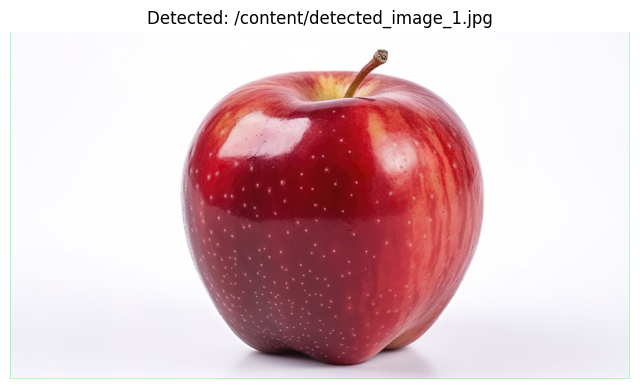

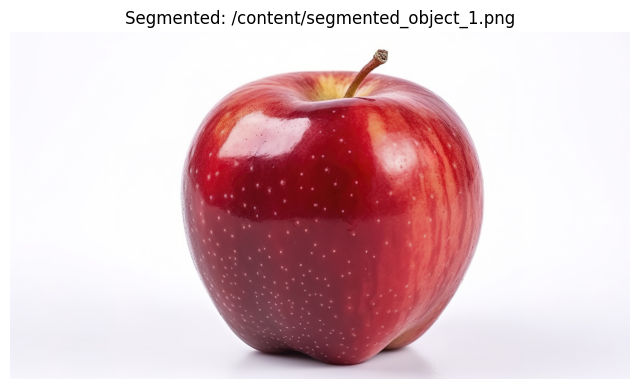

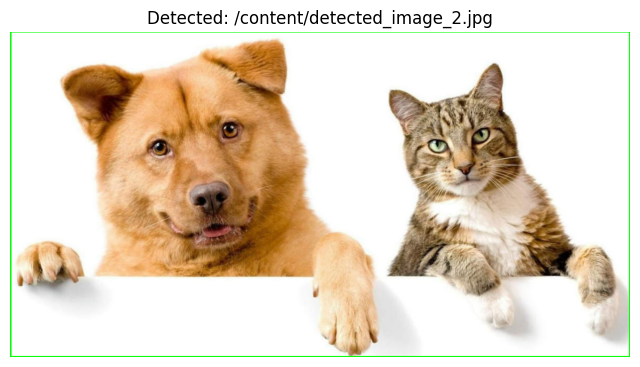

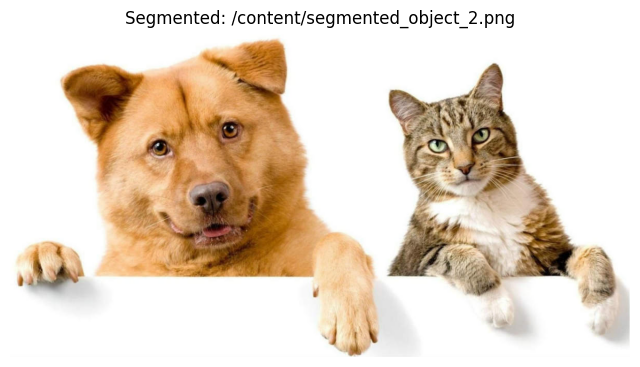

In [6]:

#Task 1-C

import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(img, title=''):
    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def get_main_object_mask(img):
    # Convert to HSV for color segmentation
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Use Otsu's threshold on V channel for robust brightness separation
    v = hsv[:,:,2]
    _, v_mask = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Edge mask
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 40, 120)
    # Dilate edges to make them thicker
    edges = cv2.dilate(edges, np.ones((5,5), np.uint8), iterations=2)
    # Fill holes in the edge mask
    edges_filled = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, np.ones((15,15), np.uint8))

    # Combine color and edge masks
    combined_mask = cv2.bitwise_or(v_mask, edges_filled)
    # Morphological closing to fill gaps
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, np.ones((25,25), np.uint8))
    # Remove small blobs
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(combined_mask)
    # Keep only the largest blob (main object)
    if num_labels > 1:
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        main_mask = np.zeros_like(combined_mask)
        main_mask[labels == largest_label] = 255
    else:
        main_mask = combined_mask

    # Convex hull to recover missing parts
    contours, _ = cv2.findContours(main_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        hull = cv2.convexHull(np.vstack(contours))
        hull_mask = np.zeros_like(main_mask)
        cv2.drawContours(hull_mask, [hull], -1, 255, -1)
        main_mask = hull_mask

    # Final closing to smooth mask
    main_mask = cv2.morphologyEx(main_mask, cv2.MORPH_CLOSE, np.ones((31,31), np.uint8))
    return main_mask

def detect_and_segment(img_path, detected_output, segmented_output, background_color=(255,255,255)):
    img = cv2.imread(img_path)
    mask = get_main_object_mask(img)

    # Draw bounding box for detection
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    detected_img = img.copy()
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(detected_img, (x, y), (x+w, y+h), (0,255,0), 3)
    cv2.imwrite(detected_output, detected_img)
    show_image(detected_img, f'Detected: {detected_output}')

    # Segmentation: apply mask, replace background
    result = np.full_like(img, background_color)
    result[mask==255] = img[mask==255]
    cv2.imwrite(segmented_output, result)
    show_image(result, f'Segmented: {segmented_output}')

# Run for your images
detect_and_segment('/content/apple_image.jpg',
                   '/content/detected_image_1.jpg',
                   '/content/segmented_object_1.png')
detect_and_segment('/content/dog-and-cat-cover.jpg',
                   '/content/detected_image_2.jpg',
                   '/content/segmented_object_2.png')




